# Regional Bias

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
import warnings

import dask
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
import xesmf as xe
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.utils import short_iid
from tools import (
    check_equal_period,
    create_cordex_grid,
    fix_360_longitudes,
    height_temperature_correction,
    load_obs,
    mask_invalid,
    open_datasets,
    regional_means,
    regrid_dsets,
    seasonal_mean,
    standardize_unit,
    var_dic,
    variable_mapping,
)

dask.config.set(scheduler="single-threaded")

In [36]:
client = Client(dashboard_address="localhost:8787", threads_per_worker=1)
client

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42395 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42395/status,
Dashboard: http://127.0.0.1:42395/status,Workers: 16
Total threads: 16,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38011,Workers: 0
Dashboard: http://127.0.0.1:42395/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44569,Total threads: 1
Dashboard: http://127.0.0.1:38077/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:35911,


In [37]:
# Parameter papermill
index = "tas"
frequency = "mon"
domain = "EUR-11"
regridding = "bilinear"
periods = [slice("1989", "2008"), slice("1991", "2020")]
reference_regions = "PRUDENCE"

In [38]:
save_results_path = os.path.abspath(
    os.path.join(os.getcwd(), "..", "intermediate-results")
)
save_figure_path = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))

In [39]:
variable = var_dic[index]["variable"]

In [40]:
eur_colors = pd.read_csv("eurocordex_models.csv")

In [41]:
# prudence
regions = regionmask.defined_regions.prudence

In [42]:
rotated_grid = create_cordex_grid("EUR-11")  # No matter CMIP5 or CMIP6

## E-OBS is used as the reference dataset for all the analysis
It is used to calculate bias not only respect to CORDEX, but also in comparison wit other reanalyses and observational dataset, to assess the uncertaintly of the observational dataset

In [43]:
ref_seasmean_periods = {}
for period in periods:
    # load, regrid and calculate seasonal means
    eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
    eobs = obs.eobs(variables=eobs_var, add_mask=False).sel(time=period)
    eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)
    eobs = standardize_unit(eobs, variable)
    # eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
    # unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
    regridder = xe.Regridder(
        eobs, rotated_grid, method=regridding, unmapped_to_nan=True
    )
    ref_on_rotated = regridder(eobs)
    if not check_equal_period(ref_on_rotated, period):
        print(f"Temporal coverage of dataset does not match with {period}")
    ref_seasmean = seasonal_mean(ref_on_rotated[eobs_var].sel(time=period)).compute()
    ref_seasmean_periods[f"{period.start}-{period.stop}"] = ref_seasmean

Convert celsius to kelvin


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Convert celsius to kelvin


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.90 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


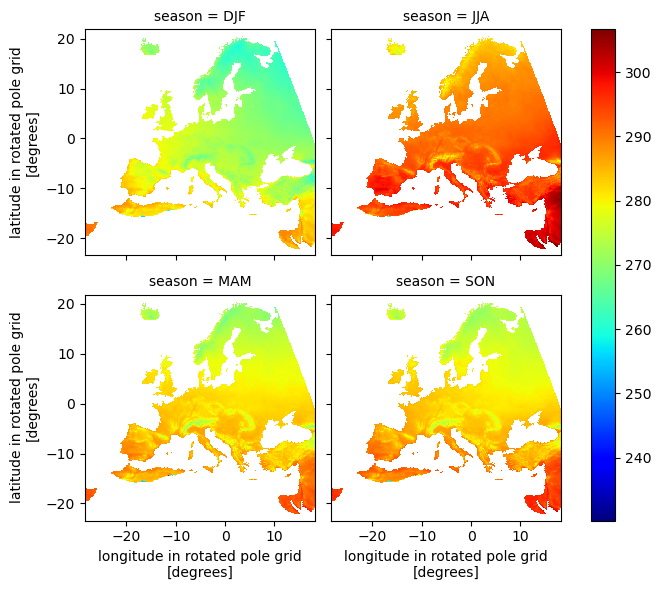

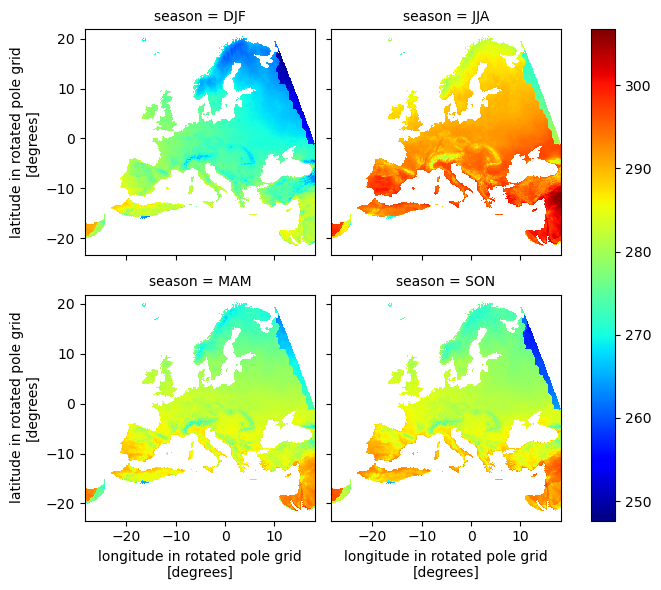

In [44]:
for period in periods:
    ref_seasmean_periods[f"{period.start}-{period.stop}"].plot(
        col="season", col_wrap=2, cmap="jet"
    )

## CERRA and ERA5

merging era5 with orog
merging era5 with sftlf


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


merging cerra with orog
merging cerra with sftlf


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 18.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


merging era5 with orog
merging era5 with sftlf


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


merging cerra with orog
merging cerra with sftlf


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 18.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


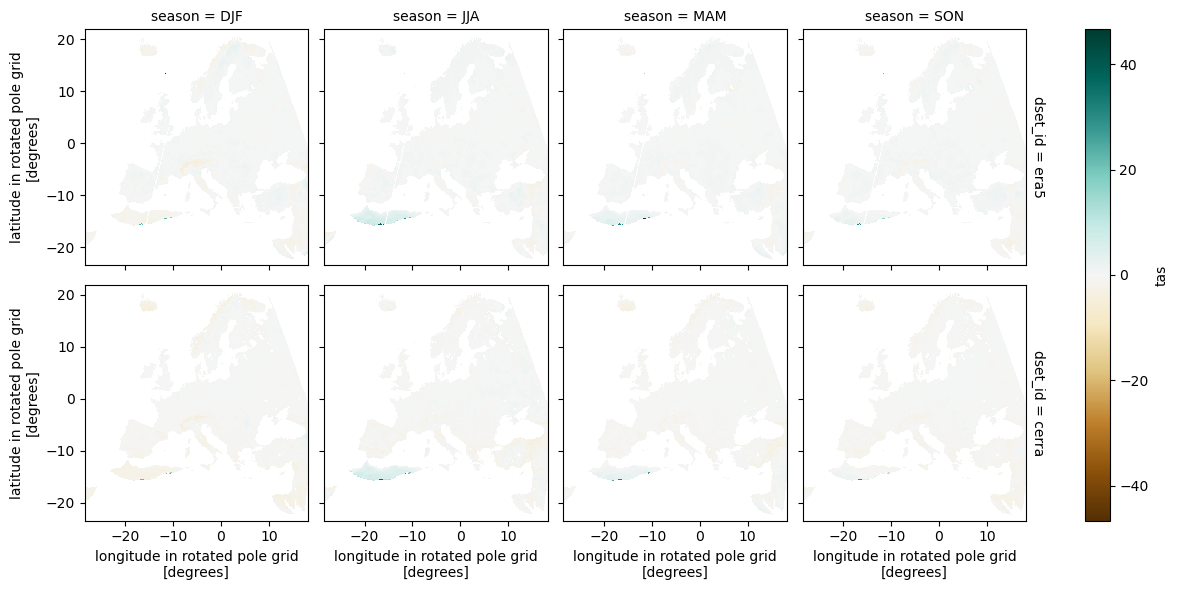

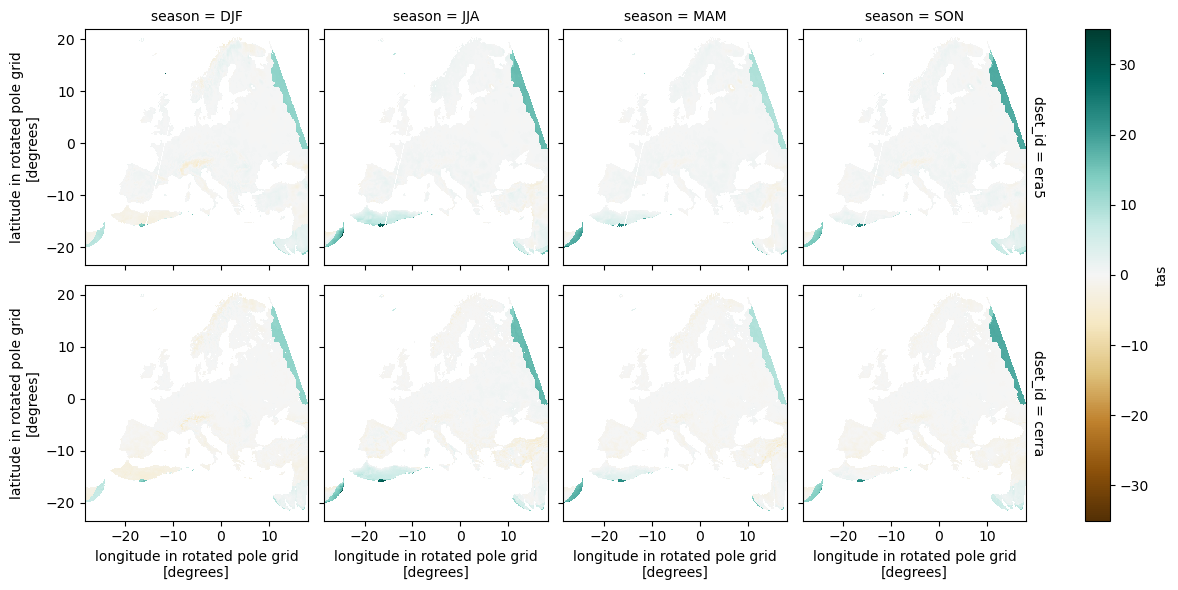

In [45]:
for period in periods:

    # Load eobs (CERRA and ERA5)
    dsets = {}
    for dset in var_dic[variable]["datasets"]:
        ds = load_obs(variable, dset, add_fx=True, mask=True)
        ds = ds.sel(time=period).compute()
        ds = fix_360_longitudes(ds, lonname="longitude")
        if not variable_mapping[dset][variable] == variable:
            ds = ds.rename_vars({variable_mapping[dset][variable]: variable})
        ds = standardize_unit(ds, variable)
        dsets[dset] = ds

    # Check temporal coverage
    for dset in dsets.keys():
        if not check_equal_period(dsets[dset], period):
            print(f"Temporal coverage of {dset} does not match with {period}")

    # Regrid
    for dset, ds in dsets.items():
        regridder = xe.Regridder(
            ds, rotated_grid, method=regridding, unmapped_to_nan=True
        )
        dsets[dset] = regridder(ds)

    if variable == "tas":
        for dset in dsets:
            h_c = height_temperature_correction(
                dsets[dset].orog, ref_on_rotated.elevation
            )
            dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

    # Calculate seasonal_mean bias respect to the reference dataset
    ref_seasmean = ref_seasmean_periods[f"{period.start}-{period.stop}"]
    if var_dic[variable]["diff"] == "abs":
        diffs = {
            dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
            - (ref_seasmean)
            for dset_id, ds in dsets.items()
            if variable in ds.variables
        }
    elif var_dic[variable]["diff"] == "rel":
        diffs = {
            dset_id: 100
            * (
                seasonal_mean(ds[[variable]].sel(time=period)).compute()
                - (ref_seasmean)
            )
            / (ref_seasmean)
            for dset_id, ds in dsets.items()
            if variable in ds.variables
        }
    obs_seasonal_bias = xr.concat(
        list(diffs.values()),
        dim=xr.DataArray(
            list(map(lambda x: x, diffs.keys())),
            dims="dset_id",
        ),
        compat="override",
        coords="minimal",
    )
    # Delete cell with high relative differences (arid areas for precipitation)
    obs_seasonal_bias[variable] = obs_seasonal_bias[variable].where(
        (obs_seasonal_bias[variable] <= 1000) & (obs_seasonal_bias[variable] >= -1000)
    )
    # Plot
    obs_seasonal_bias[variable].plot(row="dset_id", col="season", cmap="BrBG")
    # Calculate regional means
    obs_regions = regional_means(
        obs_seasonal_bias, regions, aggr=var_dic[index]["aggr"]
    )
    # Save results
    obs_regions.to_netcdf(
        f"{save_results_path}/{index}_obs_{reference_regions}_{period.start}-{period.stop}.nc"
    )

## CMIP6 and CMIP5

In [46]:
CMIP_dic = {
    "CMIP6": "ERA5",
    "CMIP5": "ERAINT",
}

Found: ['ALARO1-SFX', 'CCLM6-0-1-URB', 'CCLM6-0-1-URB-ESG', 'CNRM-ALADIN64E1', 'HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E', 'REMO2020-2-2', 'REMO2020-2-2-MR2', 'REMO2020-2-2-iMOVE', 'REMO2020-2-2-iMOVE-LUC', 'RegCM5-0'] for variables: ['tas']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.EC-Earth3-Veg.ssp370.r2i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.MPI-ESM1-2-HR.ssp370.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.EC-Earth3-Veg.ssp126.r3i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.EC-Earth3-Veg.historical.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.KNMI.NorESM2-MM.ssp370.r1i1p1f1.RACMO23E.v1-r1.fx.v20241216
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.KNMI.CNRM-ESM2-1.historical.r1i1p1f2.RACMO23E.v1-r1.fx.v20241216
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.f

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
  warnings.warn(


Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328 will be ignored...
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: "Receive multiple variables for key 'grid_mapping': ['rotated_pole', 'crs']. Expected only one. Please pass a list ['grid_mapping'] instead to get all variables matching 'grid_mapping'."
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: Found multiple grid mapping variables ['rotated_pole', 'crs']
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: Using crs as the grid mapping variable name. Pl

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
  warnings.warn(message)


Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328 will be ignored...
Fix failed for CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
Dataset CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415 will be ignored...


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
  warnings.warn(message)


Fix failed for CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
Dataset CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415 will be ignored...
merging CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205 with CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
merging CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.mon.v20241216 with CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.fx.v20241216
merging CORDEX-CMIP6.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.mon.v20240920 with CORDEX-CMIP6.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.fx.v20240920
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.60 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Found: ['ALARO1-SFX', 'CCLM6-0-1-URB', 'CCLM6-0-1-URB-ESG', 'CNRM-ALADIN64E1', 'HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E', 'REMO2020-2-2', 'REMO2020-2-2-MR2', 'REMO2020-2-2-iMOVE', 'REMO2020-2-2-iMOVE-LUC', 'RegCM5-0'] for variables: ['tas']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.fx.v20241120
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.fx.v20241120: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.fx.v20241120: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.mon.v20241216
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.CNRM-ESM2-1.ssp126.r1i1p1f2.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 61 datasets
decoding dataset CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.mon.v20241120
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.mon.v20241120: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 61 datasets


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
  warnings.warn(


Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328 will be ignored...
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: "Receive multiple variables for key 'grid_mapping': ['rotated_pole', 'crs']. Expected only one. Please pass a list ['grid_mapping'] instead to get all variables matching 'grid_mapping'."
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: Found multiple grid mapping variables ['rotated_pole', 'crs']
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: Using crs as the grid mapping variable name. Pl

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
  warnings.warn(


Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328 will be ignored...


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
  warnings.warn(message)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
  warnings.warn(message)


Fix failed for CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
Dataset CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415 will be ignored...
Fix failed for CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
Dataset CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415 will be ignored...
merging CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.mon.v20241216 with CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.fx.v20241216
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.mon.v202

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.57 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-pa

Found: ['ALADIN53', 'ALADIN63', 'ALARO-0', 'CCLM4-8-17', 'COSMO-crCLIM-v1-1', 'HadREM3-GA7-05', 'RACMO22E', 'RCA4', 'REMO2009', 'REMO2015', 'RegCM4-2'] for variables: ['tas']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX.EUR-11.SMHI.ERAINT.evaluation.r0i0p0.RCA4.v1.fx.v20131026
Found 22 datasets
decoding dataset CORDEX.EUR-11.GERICS.ERAINT.evaluation.r0i0p0.REMO2015.v1.fx.v20180813
Warning for CORDEX.EUR-11.GERICS.ERAINT.evaluation.r0i0p0.REMO2015.v1.fx.v20180813: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX.EUR-11.GERICS.ERAINT.evaluation.r0i0p0.REMO2015.v1.fx.v20180813: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 22 datasets
decoding dataset CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r1i1p1.REMO2009.v1.mon.v20160525
Found 22 datasets
decoding dataset CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r0i0p0.REMO2009.v1.fx.v20160525
Warning for CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r0i0p0.REMO2009.v1.fx.v20160525: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r0i0p0.REMO2009.v1.fx.v20160525: Variable(s) referenced in cell_measures not

decoding dataset CORDEX.EUR-11.SMHI.ERAINT.evaluation.r0i0p0.RCA4.v1.fx.v20131026
Found 22 datasets
decoding dataset CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r1i1p1.REMO2009.v1.mon.v20160525
Found 22 datasets
decoding dataset CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN63.v1.mon.v20191118
Found 22 datasets
decoding dataset CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r0i0p0.REMO2009.v1.fx.v20160525
Warning for CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r0i0p0.REMO2009.v1.fx.v20160525: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r0i0p0.REMO2009.v1.fx.v20160525: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 22 datasets
decoding dataset CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN63.v1.fx.v20191118
Found 22 datasets
decoding dataset CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.fx.v20200706
Warning for CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05

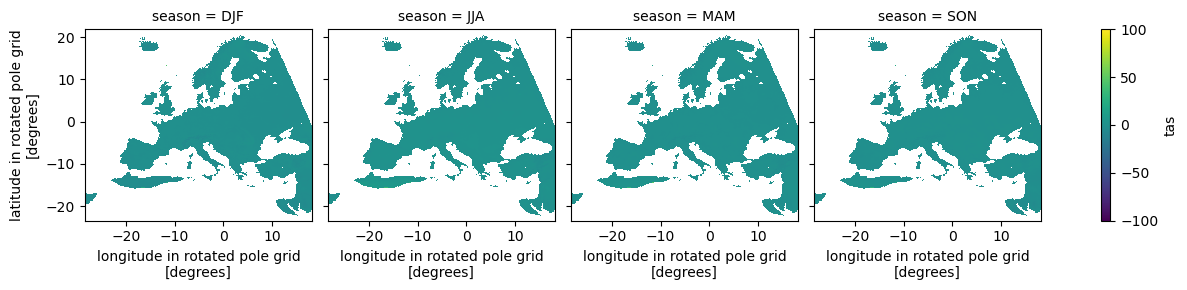

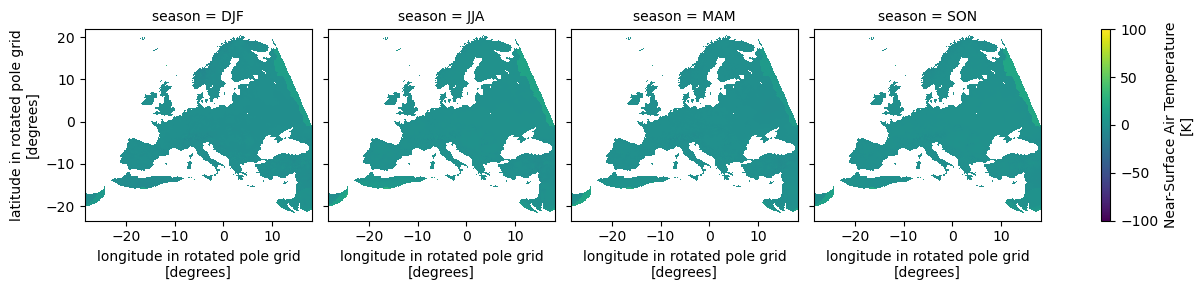

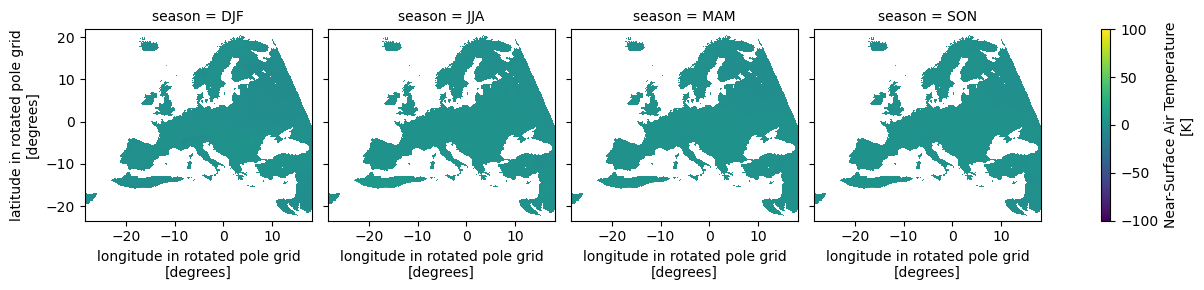

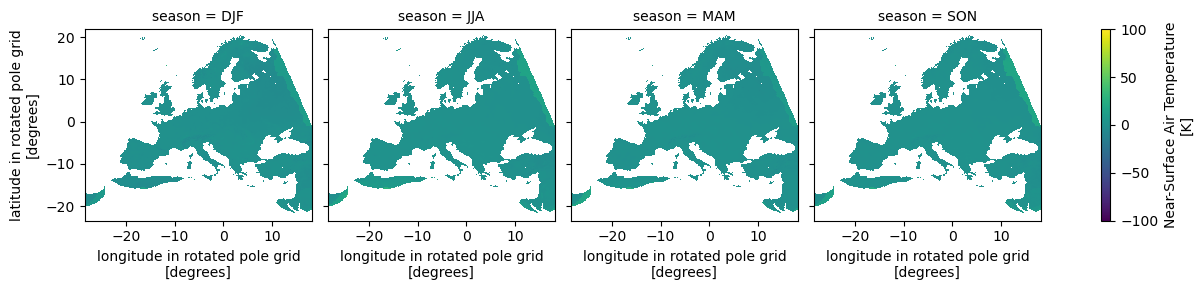

In [47]:
for mip_era, driving_source_id in CMIP_dic.items():
    for period in periods:
        dsets = open_datasets(
            [variable],
            frequency=frequency,
            driving_source_id=driving_source_id,
            mask=True,
            add_missing_bounds=False,
        )
        for dset in dsets.keys():
            if not check_equal_period(dsets[dset], period):
                print(f"Temporal coverage of {dset} does not match with {period}")

        for dset in dsets.keys():
            dsets[dset] = standardize_unit(dsets[dset], variable)

        dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

        if variable == "tas":
            for dset in dsets:
                h_c = height_temperature_correction(
                    dsets[dset].orog, ref_on_rotated.elevation
                )
                dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

        ref_seasmean = ref_seasmean_periods[f"{period.start}-{period.stop}"]
        if var_dic[index]["diff"] == "abs":
            diffs = {
                dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
                - ref_seasmean
                for dset_id, ds in dsets.items()
                if variable in ds.variables
            }
        elif var_dic[index]["diff"] == "rel":
            diffs = {
                dset_id: 100
                * (
                    seasonal_mean(ds[[variable]].sel(time=period)).compute()
                    - (ref_seasmean)
                )
                / (ref_seasmean)
                for dset_id, ds in dsets.items()
                if variable in ds.variables
            }

        seasonal_bias = xr.concat(
            list(diffs.values()),
            dim=xr.DataArray(
                list(
                    map(
                        lambda x: short_iid(x, ["source_id"], delimiter="-"),
                        diffs.keys(),
                    )
                ),
                dims="dset_id",
            ),
            compat="override",
            coords="minimal",
        )

        seasonal_bias[variable] = seasonal_bias[variable].where(
            (seasonal_bias[variable] <= 1000) & (seasonal_bias[variable] >= -1000)
        )

        seasonal_bias[variable].isel(dset_id=0).plot(col="season", vmin=-100, vmax=100)

        dset_id_regions = regional_means(
            seasonal_bias, regions, aggr=var_dic[index]["aggr"]
        )
        dset_id_regions.to_netcdf(
            f"{save_results_path}/{index}_{mip_era}_{reference_regions}_{period.start}-{period.stop}.nc"
        )

#### Load results for both CMIP5 and CMIP6 simulations

In [48]:
seasons = ["DJF", "MAM", "JJA", "SON"]

In [49]:
period = periods[0]
dset_id_regions_CMIP6_fp = xr.open_dataset(
    f"{save_results_path}/{index}_CMIP6_{reference_regions}_{period.start}-{period.stop}.nc"
)
dset_id_regions_CMIP5_fp = xr.open_dataset(
    f"{save_results_path}/{index}_CMIP5_{reference_regions}_{period.start}-{period.stop}.nc"
)

period = periods[1]
dset_id_regions_CMIP6_sp = xr.open_dataset(
    f"{save_results_path}/{index}_CMIP6_{reference_regions}_{period.start}-{period.stop}.nc"
)
dset_id_regions_CMIP5_sp = xr.open_dataset(
    f"{save_results_path}/{index}_CMIP5_{reference_regions}_{period.start}-{period.stop}.nc"
)

In [50]:
df_CMIP6_fp = dset_id_regions_CMIP6_fp.to_dataframe().reset_index()
df_CMIP5_fp = dset_id_regions_CMIP5_fp.to_dataframe().reset_index()

df_CMIP6_sp = dset_id_regions_CMIP6_sp.to_dataframe().reset_index()
df_CMIP5_sp = dset_id_regions_CMIP5_sp.to_dataframe().reset_index()

In [51]:
period = periods[0]
df_obs = xr.open_dataset(
    f"{save_results_path}/{index}_obs_{reference_regions}_{period.start}-{period.stop}.nc"
)
df_obs_fp = df_obs.to_dataframe().reset_index()

period = periods[1]
df_obs = xr.open_dataset(
    f"{save_results_path}/{index}_obs_{reference_regions}_{period.start}-{period.stop}.nc"
)
df_obs_sp = df_obs.to_dataframe().reset_index()

In [52]:
print(np.min(df_CMIP5_fp[variable]), np.max(df_CMIP5_fp[variable]))
print(np.min(df_CMIP6_fp[variable]), np.max(df_CMIP6_fp[variable]))

-4.174420685432006 2.5913760931730954
-2.4728957087335077 1.770039239831255


In [53]:
print(np.min(df_CMIP5_sp[variable]), np.max(df_CMIP5_sp[variable]))
print(np.min(df_CMIP6_sp[variable]), np.max(df_CMIP6_sp[variable]))

-4.612102395800449 2.5735853814269913
-2.792670897885373 1.7785855176711485


/tmp/ipykernel_4059364/3188378339.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region_fp["season_num"] = df_CMIP6_region_fp["season"].apply(
/tmp/ipykernel_4059364/3188378339.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region_sp["season_num"] = df_CMIP6_region_sp["season"].apply(
/tmp/ipykernel_4059364/3188378339.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

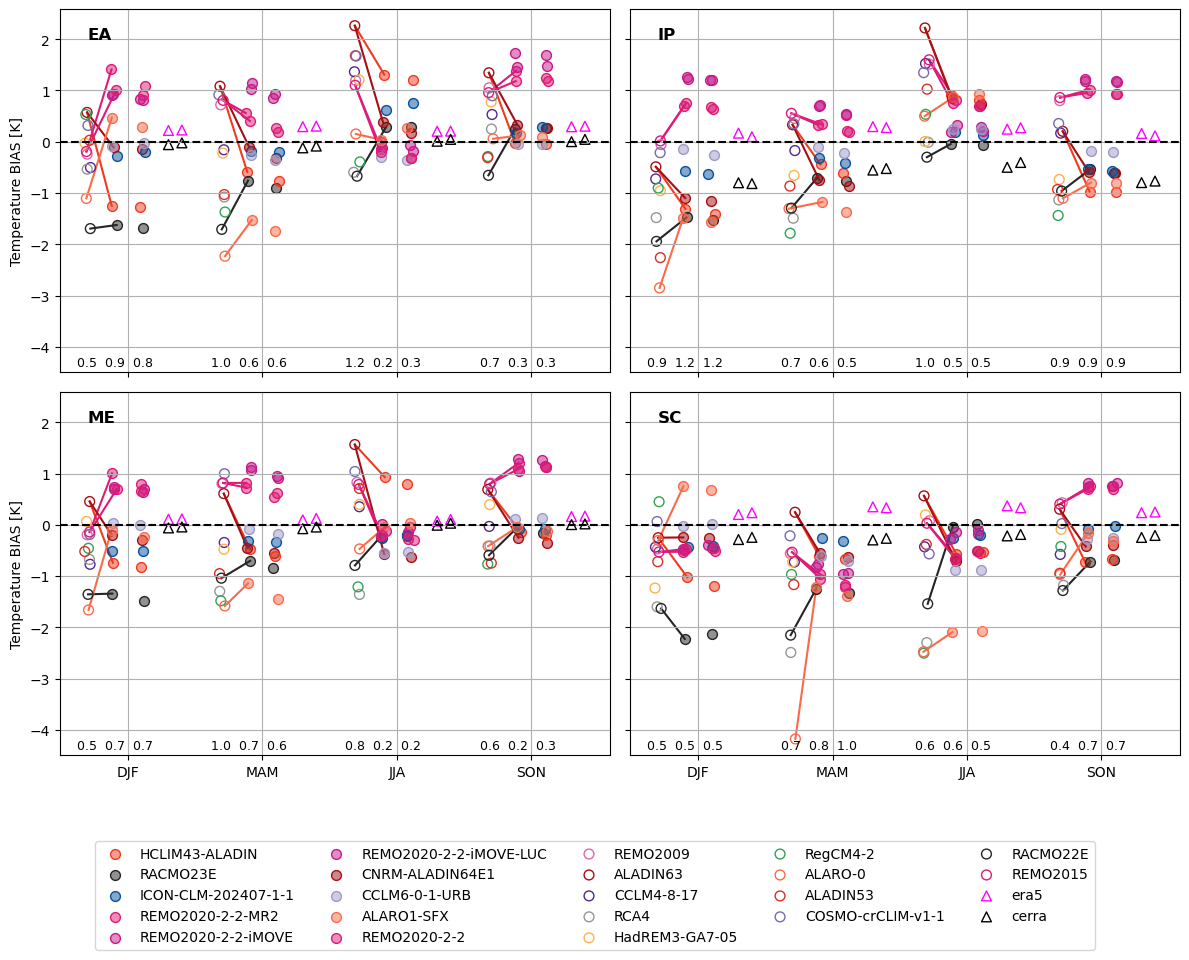

In [54]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

regs = ["EA", "IP", "ME", "SC"]
default_color = "#fb6a4a"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

handles = []
labels = []

for i, region in enumerate(regs):
    ax = axes[i]

    df_CMIP6_region_fp = df_CMIP6_fp[df_CMIP6_fp["abbrevs"] == region]
    df_CMIP5_region_fp = df_CMIP5_fp[df_CMIP5_fp["abbrevs"] == region]
    df_obs_region_fp = df_obs_fp[df_obs_fp["abbrevs"] == region]

    df_CMIP6_region_sp = df_CMIP6_sp[df_CMIP6_sp["abbrevs"] == region]
    df_CMIP5_region_sp = df_CMIP5_sp[df_CMIP5_sp["abbrevs"] == region]
    df_obs_region_sp = df_obs_sp[df_obs_sp["abbrevs"] == region]

    df_CMIP6_region_fp["season_num"] = df_CMIP6_region_fp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_CMIP6_region_sp["season_num"] = df_CMIP6_region_sp["season"].apply(
        lambda x: seasons.index(x)
    )

    df_CMIP5_region_fp["season_num"] = df_CMIP5_region_fp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_CMIP5_region_sp["season_num"] = df_CMIP5_region_sp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_obs_region_fp["season_num"] = df_obs_region_fp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_obs_region_sp["season_num"] = df_obs_region_sp["season"].apply(
        lambda x: seasons.index(x)
    )

    df_CMIP5_region_fp["season_shifted"] = (
        df_CMIP5_region_fp["season_num"]
        - 0.3
        + np.random.uniform(-0.025, 0.025, size=len(df_CMIP5_region_fp["season_num"]))
    )
    df_CMIP6_region_fp["season_shifted"] = (
        df_CMIP6_region_fp["season_num"]
        - 0.1
        + np.random.uniform(-0.025, 0.025, size=len(df_CMIP6_region_fp["season_num"]))
    )
    df_CMIP6_region_sp["season_shifted"] = (
        df_CMIP6_region_sp["season_num"]
        + 0.1
        + np.random.uniform(-0.025, 0.025, size=len(df_CMIP6_region_sp["season_num"]))
    )
    df_obs_region_fp["season_shifted"] = df_obs_region_fp["season_num"] + 0.3
    df_obs_region_sp["season_shifted"] = df_obs_region_sp["season_num"] + 0.4

    # Create lists to store the bias values for calculating median
    cmip6_biases_fp = {season: [] for season in seasons}
    cmip5_biases_fp = {season: [] for season in seasons}

    cmip6_biases_sp = {season: [] for season in seasons}
    cmip5_biases_sp = {season: [] for season in seasons}

    for idx, row in df_CMIP6_region_fp.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[eur_colors["model"] == dset_id].parent.values[0]
            if dset_id_in_table
            else None
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor=mcolors.to_rgba(color, 0.5),
            marker="o",
            s=50,
        )

        # Collect bias values for median calculation
        cmip6_biases_fp[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

        if parent is not None:
            row_cmip5 = df_CMIP5_region_fp[df_CMIP5_region_fp["dset_id"] == parent]
            if not row_cmip5.empty:
                row_cmip5 = row_cmip5[row_cmip5["season"] == row.season].iloc[0]
                ax.plot(
                    [row_cmip5["season_shifted"], row["season_shifted"]],
                    [row_cmip5[variable], row[variable]],
                    color=color,
                    linestyle="-",
                    zorder=0,
                )

    for idx, row in df_CMIP6_region_sp.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[eur_colors["model"] == dset_id].parent.values[0]
            if dset_id_in_table
            else None
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor=mcolors.to_rgba(color, 0.5),
            marker="o",
            s=50,
        )

        # Collect bias values for median calculation
        cmip6_biases_sp[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_CMIP5_region_fp.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="o",
            s=50,
        )

        # Collect bias values for median calculation
        cmip5_biases_fp[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_region_fp.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            color = "magenta"
        else:
            color = "black"
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="^",
            s=50,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_region_sp.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            color = "magenta"
        else:
            color = "black"
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="^",
            s=50,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    axes[0].set_ylabel(var_dic[index]["name"])
    axes[2].set_ylabel(var_dic[index]["name"])
    # Add region label in the top-left corner of each subplot
    ax.text(
        0.05,
        0.95,
        region,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        color="black",
        weight="bold",
    )

    ax.set_xticks([0, 1, 2, 3])  # Adjust tick positions according to the shift
    ax.set_xticklabels(seasons)  # Set the names of the seasons as labels

    ax.grid(True)
    ax.axhline(0, color="black", linestyle="--")

    if index == "pr":
        ax.fill_between([-0.5, 3.5], 0, 25, color="#cceeff", alpha=0.35)

    # Calculate and display the absolute median bias for each season for both CMIP5 and CMIP6
    for j, season in enumerate(seasons):
        cmip6_median_fp = (
            np.nanmedian(cmip6_biases_fp[season]) if cmip6_biases_fp[season] else np.nan
        )
        cmip5_median_fp = (
            np.nanmedian(cmip5_biases_fp[season]) if cmip5_biases_fp[season] else np.nan
        )
        cmip6_median_sp = (
            np.nanmedian(cmip6_biases_sp[season]) if cmip6_biases_sp[season] else np.nan
        )
        cmip5_median_sp = (
            np.nanmedian(cmip5_biases_sp[season]) if cmip5_biases_sp[season] else np.nan
        )

        # Add the absolute median bias text below the season labels
        ax.text(
            j - 0.1,
            0.01,  # x in data coords, y as fraction of axes height (just above bottom)
            f"{cmip5_median_fp:.1f}  {cmip6_median_fp:.1f}  {cmip6_median_sp:.1f}",
            fontsize=9,
            verticalalignment="bottom",
            horizontalalignment="center",
            color="black",
            transform=ax.get_xaxis_transform(),  # y in axes coords, x in data coords
        )
#        ax.text(j, var_dic[index]['range'][0]+0.5, f'{cmip5_median:.1f}  {cmip6_median:.1f}',
#                fontsize=10, verticalalignment='top', horizontalalignment='center', color='black')

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    fontsize=10,
)


plt.tight_layout()
plt.show()
fig.savefig(
    f"{save_figure_path}/{reference_regions}_A_bias_{index}.png",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)

/tmp/ipykernel_4059364/233160009.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region_fp["season_num"] = df_CMIP6_region_fp["season"].apply(
/tmp/ipykernel_4059364/233160009.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region_sp["season_num"] = df_CMIP6_region_sp["season"].apply(
/tmp/ipykernel_4059364/233160009.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

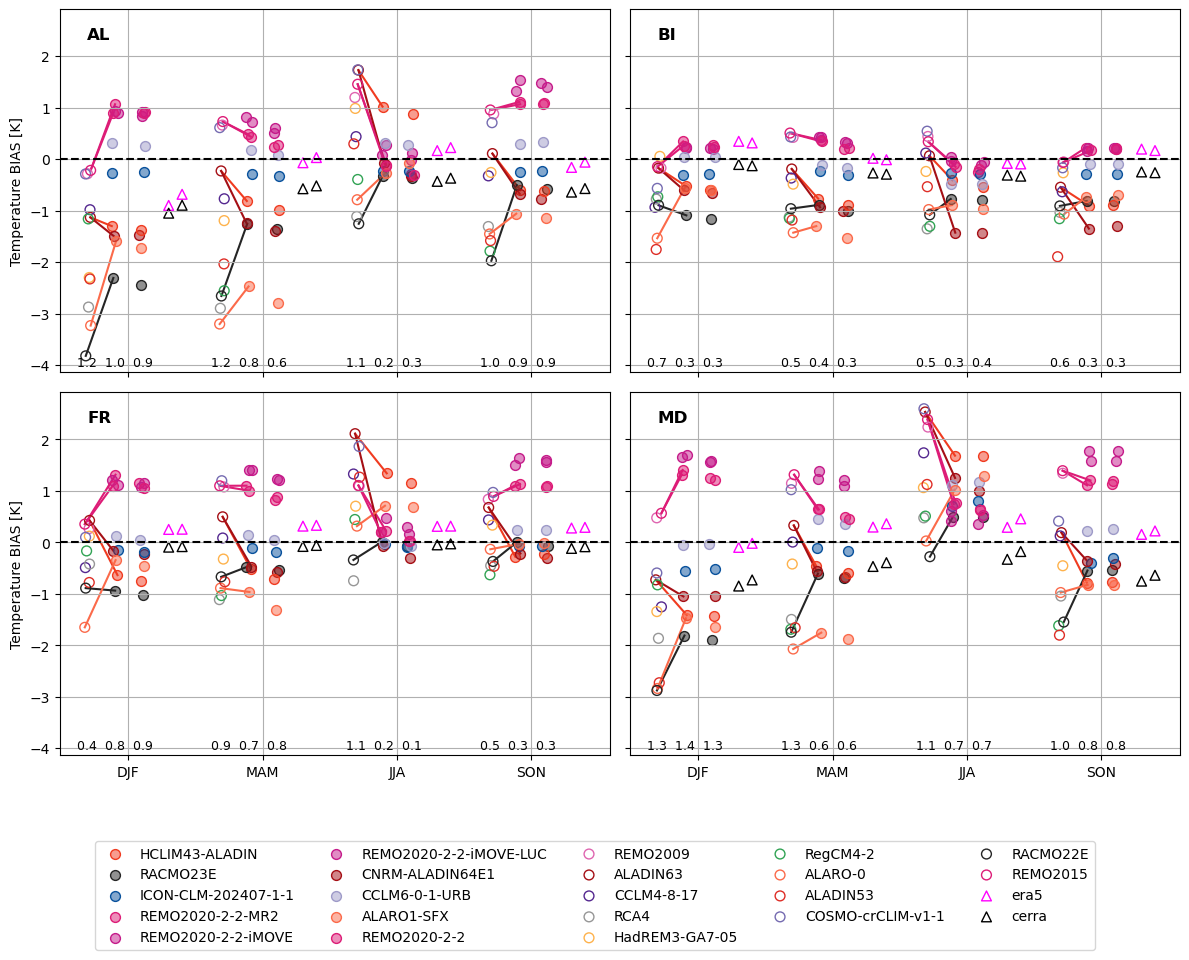

In [55]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

regs = ["AL", "BI", "FR", "MD"]
default_color = "#fb6a4a"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

handles = []
labels = []

for i, region in enumerate(regs):
    ax = axes[i]

    df_CMIP6_region_fp = df_CMIP6_fp[df_CMIP6_fp["abbrevs"] == region]
    df_CMIP5_region_fp = df_CMIP5_fp[df_CMIP5_fp["abbrevs"] == region]
    df_obs_region_fp = df_obs_fp[df_obs_fp["abbrevs"] == region]

    df_CMIP6_region_sp = df_CMIP6_sp[df_CMIP6_sp["abbrevs"] == region]
    df_CMIP5_region_sp = df_CMIP5_sp[df_CMIP5_sp["abbrevs"] == region]
    df_obs_region_sp = df_obs_sp[df_obs_sp["abbrevs"] == region]

    df_CMIP6_region_fp["season_num"] = df_CMIP6_region_fp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_CMIP6_region_sp["season_num"] = df_CMIP6_region_sp["season"].apply(
        lambda x: seasons.index(x)
    )

    df_CMIP5_region_fp["season_num"] = df_CMIP5_region_fp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_CMIP5_region_sp["season_num"] = df_CMIP5_region_sp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_obs_region_fp["season_num"] = df_obs_region_fp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_obs_region_sp["season_num"] = df_obs_region_sp["season"].apply(
        lambda x: seasons.index(x)
    )

    df_CMIP5_region_fp["season_shifted"] = (
        df_CMIP5_region_fp["season_num"]
        - 0.3
        + np.random.uniform(-0.025, 0.025, size=len(df_CMIP5_region_fp["season_num"]))
    )
    df_CMIP6_region_fp["season_shifted"] = (
        df_CMIP6_region_fp["season_num"]
        - 0.1
        + np.random.uniform(-0.025, 0.025, size=len(df_CMIP6_region_fp["season_num"]))
    )
    df_CMIP6_region_sp["season_shifted"] = (
        df_CMIP6_region_sp["season_num"]
        + 0.1
        + np.random.uniform(-0.025, 0.025, size=len(df_CMIP6_region_sp["season_num"]))
    )
    df_obs_region_fp["season_shifted"] = df_obs_region_fp["season_num"] + 0.3
    df_obs_region_sp["season_shifted"] = df_obs_region_sp["season_num"] + 0.4

    # Create lists to store the bias values for calculating median
    cmip6_biases_fp = {season: [] for season in seasons}
    cmip5_biases_fp = {season: [] for season in seasons}

    cmip6_biases_sp = {season: [] for season in seasons}
    cmip5_biases_sp = {season: [] for season in seasons}

    for idx, row in df_CMIP6_region_fp.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[eur_colors["model"] == dset_id].parent.values[0]
            if dset_id_in_table
            else None
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor=mcolors.to_rgba(color, 0.5),
            marker="o",
            s=50,
        )

        # Collect bias values for median calculation
        cmip6_biases_fp[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

        if parent is not None:
            row_cmip5 = df_CMIP5_region_fp[df_CMIP5_region_fp["dset_id"] == parent]
            if not row_cmip5.empty:
                row_cmip5 = row_cmip5[row_cmip5["season"] == row.season].iloc[0]
                ax.plot(
                    [row_cmip5["season_shifted"], row["season_shifted"]],
                    [row_cmip5[variable], row[variable]],
                    color=color,
                    linestyle="-",
                    zorder=0,
                )

    for idx, row in df_CMIP6_region_sp.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[eur_colors["model"] == dset_id].parent.values[0]
            if dset_id_in_table
            else None
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor=mcolors.to_rgba(color, 0.5),
            marker="o",
            s=50,
        )

        # Collect bias values for median calculation
        cmip6_biases_sp[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_CMIP5_region_fp.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="o",
            s=50,
        )

        # Collect bias values for median calculation
        cmip5_biases_fp[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_region_fp.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            color = "magenta"
        else:
            color = "black"
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="^",
            s=50,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_region_sp.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            color = "magenta"
        else:
            color = "black"
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="^",
            s=50,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    axes[0].set_ylabel(var_dic[index]["name"])
    axes[2].set_ylabel(var_dic[index]["name"])
    # Add region label in the top-left corner of each subplot
    ax.text(
        0.05,
        0.95,
        region,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        color="black",
        weight="bold",
    )

    ax.set_xticks([0, 1, 2, 3])  # Adjust tick positions according to the shift
    ax.set_xticklabels(seasons)  # Set the names of the seasons as labels

    ax.grid(True)
    ax.axhline(0, color="black", linestyle="--")

    if index == "pr":
        ax.fill_between([-0.5, 3.5], 0, 25, color="#cceeff", alpha=0.35)

    # Calculate and display the absolute median bias for each season for both CMIP5 and CMIP6
    for j, season in enumerate(seasons):
        cmip6_median_fp = (
            np.nanmedian(cmip6_biases_fp[season]) if cmip6_biases_fp[season] else np.nan
        )
        cmip5_median_fp = (
            np.nanmedian(cmip5_biases_fp[season]) if cmip5_biases_fp[season] else np.nan
        )
        cmip6_median_sp = (
            np.nanmedian(cmip6_biases_sp[season]) if cmip6_biases_sp[season] else np.nan
        )
        cmip5_median_sp = (
            np.nanmedian(cmip5_biases_sp[season]) if cmip5_biases_sp[season] else np.nan
        )

        # Add the absolute median bias text below the season labels
        ax.text(
            j - 0.1,
            0.01,  # x in data coords, y as fraction of axes height (just above bottom)
            f"{cmip5_median_fp:.1f}  {cmip6_median_fp:.1f}  {cmip6_median_sp:.1f}",
            fontsize=9,
            verticalalignment="bottom",
            horizontalalignment="center",
            color="black",
            transform=ax.get_xaxis_transform(),  # y in axes coords, x in data coords
        )
#        ax.text(j, var_dic[index]['range'][0]+0.5, f'{cmip5_median:.1f}  {cmip6_median:.1f}',
#                fontsize=10, verticalalignment='top', horizontalalignment='center', color='black')

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    fontsize=10,
)


plt.tight_layout()
plt.show()
fig.savefig(
    f"{save_figure_path}/{reference_regions}_B_bias_{index}.png",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)